In [2]:
import numpy as np
import matplotlib.pylab as plt
from math import *
#from sklearn.models import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# rcParams['figure.figsize'] = 12, 8


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import mean_absolute_percentage_error as mape 
from sklearn.metrics import r2_score as r2 
from sklearn.metrics import explained_variance_score as evs 

In [6]:
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

In [7]:
def CC(y_pred, y_true):
    return np.corrcoef(y_pred, y_true)[0][1]

In [8]:
import pickle

#### April Dataset

In [9]:
df = pd.read_csv('inputs/DS1_1440.csv')

In [10]:
from processing import create_features, split_data

In [11]:
train_len = int(.6*df.shape[0])
train_data, val_data, test_data = split_data(df.wind_speed.values, train_len)

In [12]:
from lssvm import LSSVMRegression as LSSVM

In [13]:
def get_data(file_name):
    file = open(file_name, 'rb')
    data = pickle.load(file)
    file.close()
    return data

In [14]:
svmd_ebqpso_1 = get_data('svmd_ebqpso_1')

In [15]:
error_values = get_data('error_svmd_eb_lssvm_1')

In [16]:
test_preds = []

#### Get Predicted Values

##### LSSVM-EBQPSO Model

In [17]:
lssvm_ebqpso_1 = get_data('lssvm_ebqpso_1')

In [18]:
lssvm_ebqpso_1['params'][-1]

1.0

In [19]:
params = lssvm_ebqpso_1['params']
train_data_, _, test_data_ = split_data(df.wind_speed.values, train_len)
x_train_, y_train_ = create_features(train_data_, int(params[-1]))
x_test_, y_test_ = create_features(test_data_, int(params[-1]))
reg = LSSVM(gamma=params[0], sigma=params[1])
reg.fit(x_train_, y_train_)
lssvm_ebqpso_preds_1 = reg.predict(x_test_)

##### SVMD-LSSVM-EBQPSO Model

In [20]:
svmds = pd.read_csv('inputs/SVMD_1.csv')

In [21]:
for i in range(len(svmd_ebqpso_1)):
    params = svmd_ebqpso_1[i][0]
    train_data_i, _, test_data_i = split_data(svmds.iloc[:, i].values, train_len)
    x_train_i, y_train_i = create_features(train_data_i, params[-1])
    x_test_i, y_test_i = create_features(test_data_i, params[-1])
    reg = LSSVM(gamma=params[0], sigma=params[1])
    reg.fit(x_train_i, y_train_i)
    test_preds.append(reg.predict(x_test_i))

In [22]:
# Get the optimum values of window sizes for each modes
window_sizes = np.array([svmd_ebqpso_1[i][0][-1] for i in svmd_ebqpso_1.keys()])

In [23]:
max_window_size = np.max(window_sizes)

In [24]:
adjusted_test_preds = np.array([
    list(test_preds[i][(max_window_size-window_sizes[i]):]) for i in range(len(window_sizes))
])

In [25]:
total_modes_preds = adjusted_test_preds.sum(axis=0)

In [26]:
total_modes_preds.shape

(276,)

In [27]:
error_values_1 = error_values[max_window_size-5:]

In [28]:
svmd_ebqpso_lssvm_preds = total_modes_preds + error_values_1

In [29]:
svmd_ebqpso_lssvm_preds.shape

(276,)

In [30]:
_, y_test = create_features(test_data, max_window_size)

In [31]:
mae(y_test, svmd_ebqpso_lssvm_preds)

0.512030131411579

In [32]:
lssvm_ebqpso_preds_1 = lssvm_ebqpso_preds_1[max_window_size-1:]

##### CNN Model

In [33]:
cnn_preds = get_data('pred_cnn_1')

In [34]:
len(cnn_preds)

283

In [35]:
cnn_preds_1 = cnn_preds[max_window_size-5:]

In [36]:
len(cnn_preds_1)

276

In [37]:
mse(y_test, cnn_preds_1)

0.6280094185605536

##### SVMD-CNN Model

In [38]:
svmd_cnn_1 = get_data('svmd_cnn_1')

In [39]:
svmd_cnn_1 = svmd_cnn_1[max_window_size-5:]

In [40]:
len(svmd_cnn_1)

276

In [41]:
mse(svmd_cnn_1, y_test)

0.5184969024484706

##### LSTM Model

In [42]:
lstm_preds_1 = get_data('lstm_1')

In [43]:
lstm_preds_1 = lstm_preds_1[max_window_size-5:]

In [44]:
len(lstm_preds_1)

276

In [45]:
mse(lstm_preds_1, y_test)

0.6201403822668996

##### SVMD-LSTM Model

In [46]:
svmd_lstm_1 = get_data('svmd_lstm_1')

In [47]:
svmd_lstm_1 = svmd_lstm_1[max_window_size-5:]

In [48]:
len(svmd_lstm_1)

276

In [49]:
mse(svmd_lstm_1, y_test)

0.6140267058798828

##### CNN-LSTM Model

In [50]:
cnn_lstm_1 = get_data('cnn_lstm_1')

In [51]:
cnn_lstm_1 = cnn_lstm_1[max_window_size-5:]

In [52]:
len(cnn_lstm_1)

276

In [53]:
mse(cnn_lstm_1, y_test)

0.6552313425621665

##### SVMD-CNN-LSTM Model

In [60]:
svmd_cnn_lstm_1 = get_data('svmd_cnn_lstm_1')

In [62]:
len(svmd_cnn_lstm_1)

283

In [56]:
svmd_cnn_lstm_1 = svmd_cnn_lstm_1[max_window_size-5:]

In [57]:
len(svmd_cnn_lstm_1)

276

In [58]:
mse(svmd_cnn_lstm_1, y_test)

87.489364554845

In [63]:
models = ['LSSVM-EBQPSO', 'Proposed', 'CNN', 'SVMD-CNN', 'LSTM', 'SVMD-LSTM', 'CNN-LSTM']
predicted_values = [
    lssvm_ebqpso_preds_1,
    svmd_ebqpso_lssvm_preds, 
    cnn_preds_1, 
    svmd_cnn_1, 
    lstm_preds_1, 
    svmd_lstm_1, 
    cnn_lstm_1
]

In [64]:
def summarize_results(models, predicted_values):
    print("Model".rjust(25), "\t RMSE \t MAE \t MAPE \t R2 \t  CC \t EVS")
    print("---------".rjust(25), "\t ---- \t ---- \t ---- \t ---- \t ---- \t ----")
    for i in range(len(models)):
        print(
            models[i].rjust(25), '\t', 
            round(rmse(y_test, predicted_values[i]), 3), '\t', 
            round(mae(y_test, predicted_values[i]), 3),  '\t',
            round(mape(y_test, predicted_values[i]), 3), '\t',
            round(r2(y_test, predicted_values[i]), 3),   '\t',
            round(CC(y_test, predicted_values[i]), 3),  '\t',
            round(evs(y_test, predicted_values[i]), 3),  '\t'
        )

In [65]:
summarize_results(models, predicted_values)

                    Model 	 RMSE 	 MAE 	 MAPE 	 R2 	  CC 	 EVS
                --------- 	 ---- 	 ---- 	 ---- 	 ---- 	 ---- 	 ----
             LSSVM-EBQPSO 	 0.785 	 0.572 	 0.066 	 0.746 	 0.865 	 0.746 	
                 Proposed 	 0.703 	 0.512 	 0.059 	 0.796 	 0.892 	 0.796 	
                      CNN 	 0.792 	 0.578 	 0.066 	 0.741 	 0.864 	 0.744 	
                 SVMD-CNN 	 0.72 	 0.533 	 0.061 	 0.786 	 0.892 	 0.795 	
                     LSTM 	 0.787 	 0.581 	 0.067 	 0.744 	 0.864 	 0.747 	
                SVMD-LSTM 	 0.784 	 0.605 	 0.067 	 0.747 	 0.89 	 0.79 	
                 CNN-LSTM 	 0.809 	 0.599 	 0.068 	 0.73 	 0.862 	 0.742 	


In [66]:
colors = ['#18a1cd', '#009076', '#fa8c00', '#857622', '#a65628', '#c24c39', '#5c5a30', '#4daf4a']

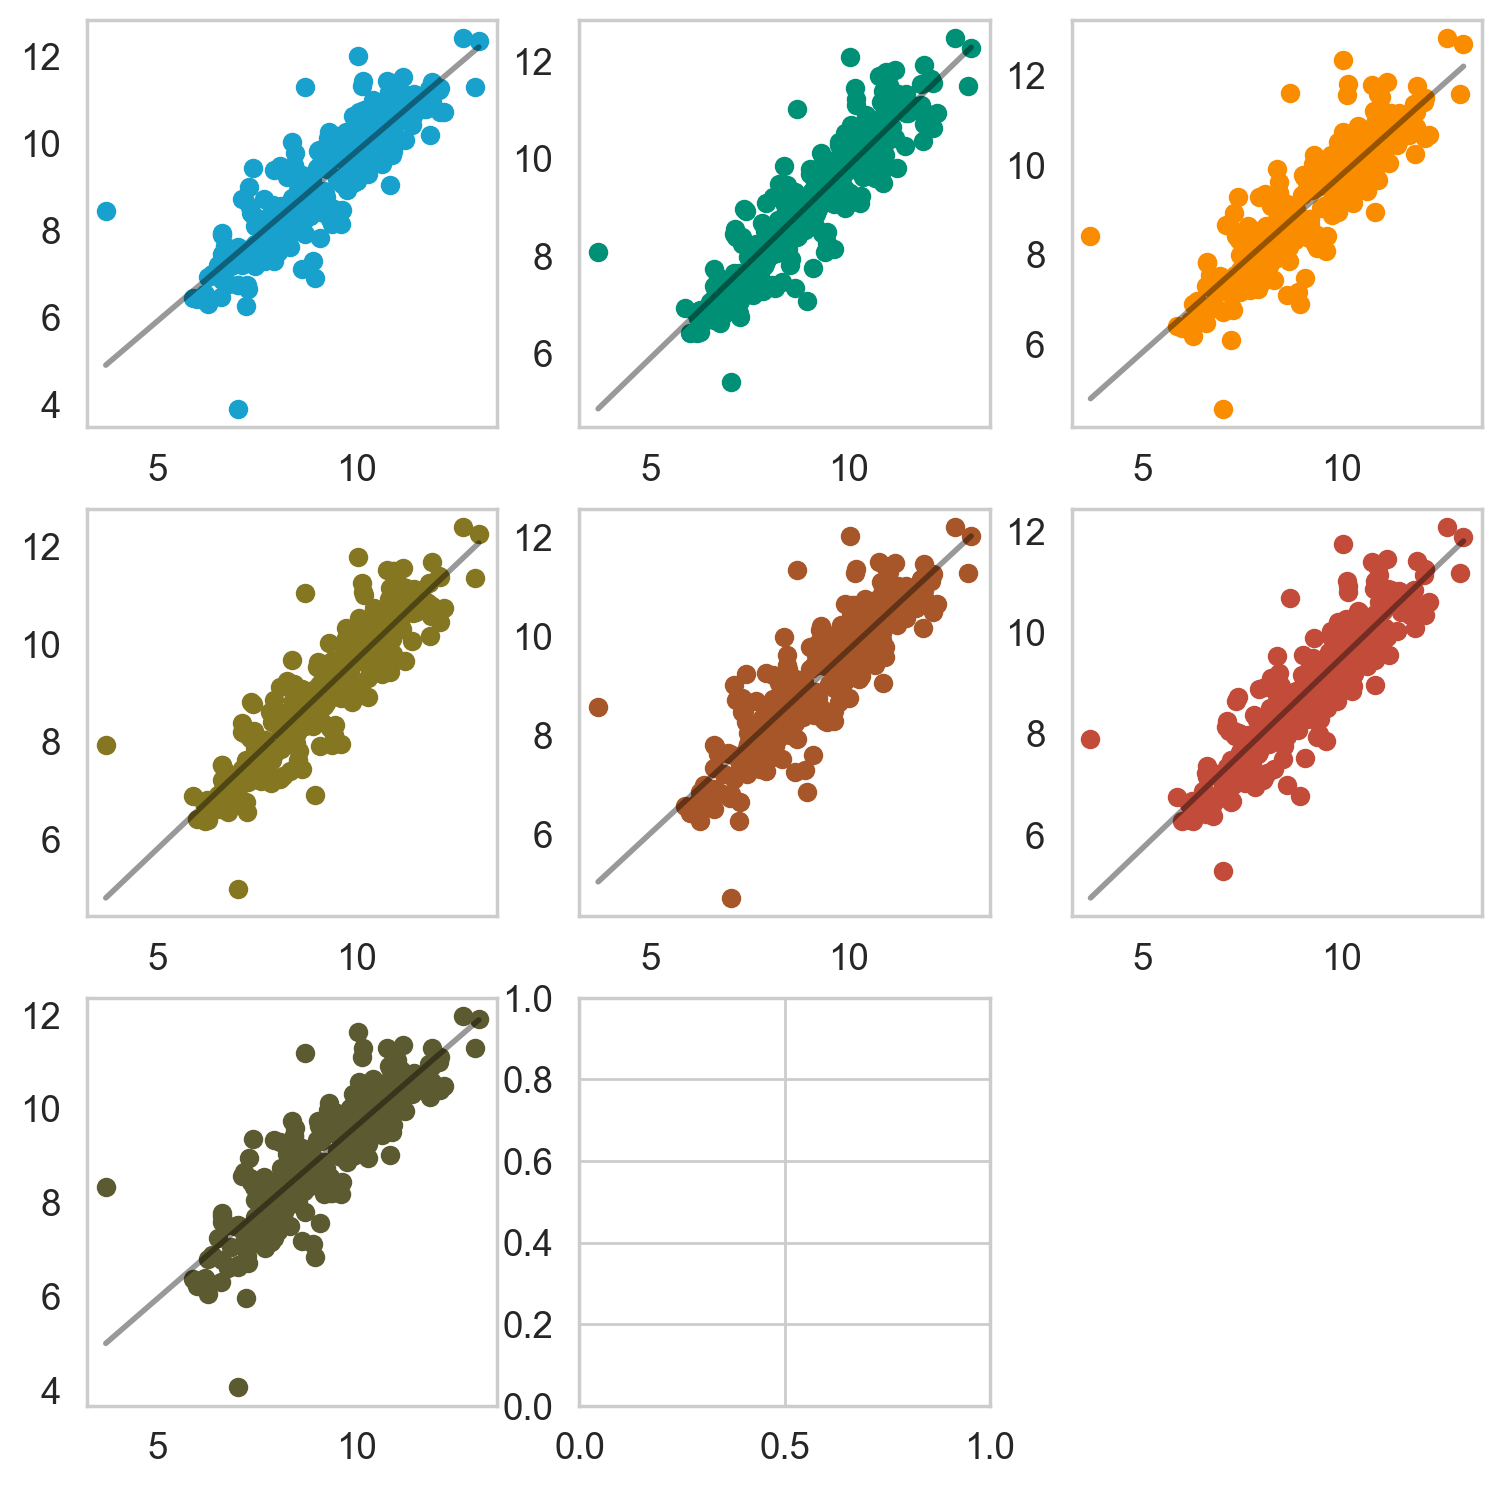

In [67]:
plt.rcParams["font.size"] = 10
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(9, 9))
fig.delaxes(axes[-1][-1])


for i in range(len(models)):
    row = i // 3
    col = i % 3
    axes[row][col].scatter(y_test, predicted_values[i], color = colors[i])
    
    m, b = np.polyfit(y_test, predicted_values[i], deg=1)

    # Create sequence of 100 numbers from 0 to 100 
    xseq = np.linspace(min(y_test), max(y_test), num=len(y_test))

    # Plot regression line
    axes[row][col].plot(xseq, b + m * xseq, color="black", lw=2, alpha=.4)

    axes[row][col].grid(False)

# plt.axis('equal')


In [294]:
all_preds = [y_test] + predicted_values

Text(0, 0.5, 'Wind speed (m/s)')

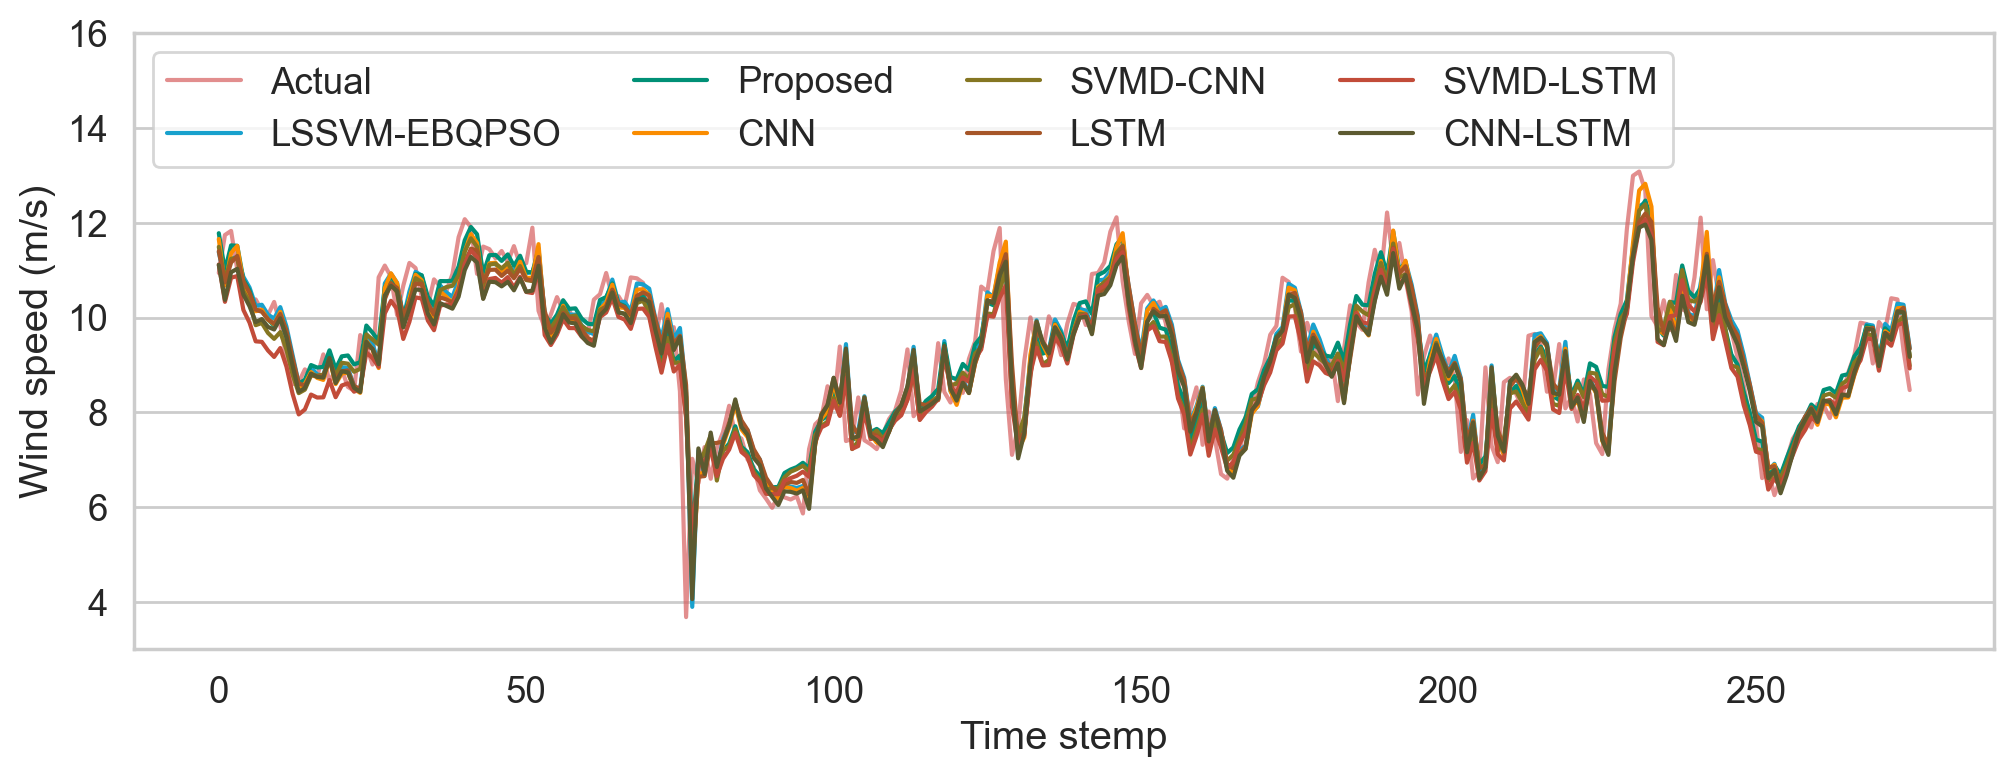

In [88]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(y_test)), y_test, color='r', alpha = .7, label='Actual')
for i, data in enumerate(predicted_values):
    ax.plot(range(len(y_test)), data, color=colors[i], label = models[i])
ax.set_ylim([3, 16])
ax.grid(axis='x')
# plt.legend(bbox_to_anchor =(0.85, 1), ncol = 4, frameon=True, framealpha=.9, borderpad = .5)
ax.legend(ncol=4, loc='upper left')
ax.set_xlabel('Time stemp')
ax.set_ylabel('Wind speed (m/s)')

In [148]:
import matplotlib as mpl
from scipy.stats import norm


def plot_error_hist(errors, colrs, d=100):
    bins=25
    fig, axs = plt.subplots(3, 3, figsize=(8, 4), dpi=d)
    fig.tight_layout()
    mpl.rcParams['xtick.labelsize'] = 10 
    mpl.rcParams['ytick.labelsize'] = 10 
    for i in range(len(models)):
        mu, std = norm.fit(errors[i])

        # for j in range(2):
        row = i // 3
        col = i % 3
        axs[row][col].hist(errors[i], bins=bins, density = True, color=colrs[i], label=models[i])
        # axs[row][col].legend()
        xmin, xmax = axs[row][col].get_xlim()
        x = np.linspace(xmin, xmax, len(errors[i]))
        p = norm.pdf(x, mu, std)
        axs[row][col].plot(x, p, 'k', linestyle = 'dashed', linewidth=2, alpha=.6)
        if col == 0:
            axs[row][col].set_ylabel("Frequency", fontsize=10)
        # axs[row][col].set_xlabel("Prediction error ("+models[i]+')', fontsize=10)
    
    # plt.savefig('errordist', dpi=d)

In [149]:
errors = [y_test-predicted_values[i] for i in range(len(predicted_values))]

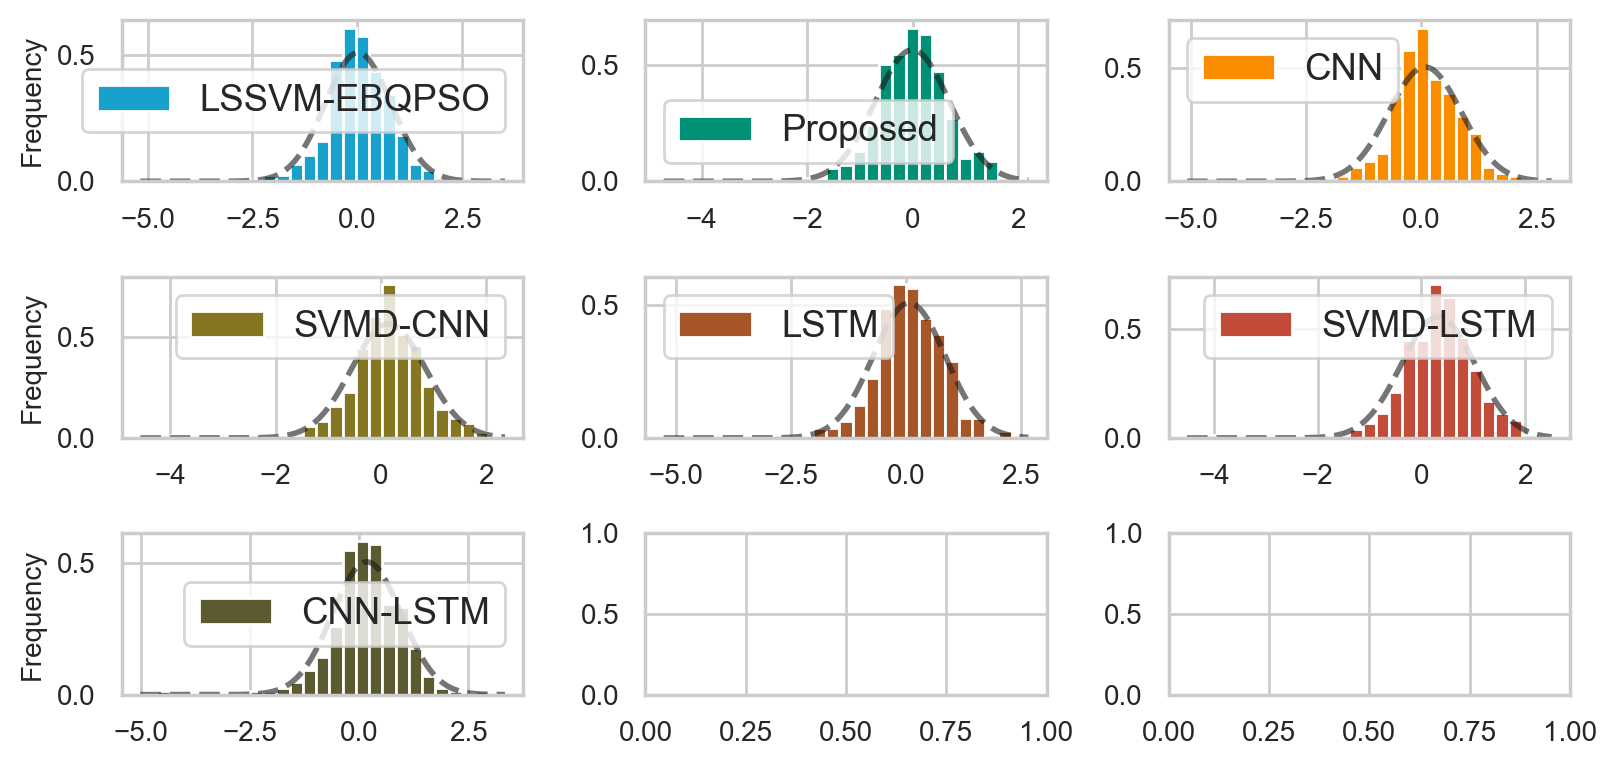

In [150]:
plot_error_hist(errors, colors)

In [332]:
import matplotlib as mpl

lbs = ['LSSVM', 'EBQPSO-LSSVM', 'BP-NN', 'LSTM']
sns.set(style="white", palette="muted", color_codes=True)
sns.despine(left=True)

def plot_error_box(errors, c = 'blue', d=100):
    bins=25
    fig, axs = plt.subplots(2, 2, figsize=(8, 4), dpi=d)
    fig.tight_layout()
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8 
    for i in range(2):
        for j in range(2):
            axs[i, j].boxplot(errors[2*i+j], showfliers=False)
            axs[i, j].set_ylabel("Frequency", fontsize=10)
            axs[i, j].set_xlabel("Prediction error ("+lbs[2*i+j]+')', fontsize=10)


<Figure size 1200x800 with 0 Axes>